$\textbf{x}\in\Omega$

$$\frac{\partial u}{\partial t}+\textbf{a}\cdot\nabla u = s$$

$\textbf{x}\in\partial\Omega_I$ inflow boundary condition

$$u = u_I$$

CG formulation

$$\int_\Omega\text{d}x~v\frac{\partial u}{\partial t} + v\,\textbf{a}\cdot\nabla u - vs=0 \quad\forall v\in V_{\text{P}}$$

$$\int_\Omega~\text{d}x~v\frac{u^{n+1} - u^n}{\Delta t} + v\,\textbf{a}\cdot\nabla\mathcal{D}(u) - vs=0 \quad\forall v\in V_{\text{P}}$$

DG formulation

$$\int_\Omega\text{d}x~v\frac{\partial u}{\partial t} - u\nabla\cdot(v\textbf{a}) - vs + \int_{\mathcal{F}}\text{d}S~\llbracket v\rrbracket\,\llbracket u\max(\textbf{a}\cdot\textbf{n}, 0)\rrbracket + \int_{\partial\Omega_I}\text{d}s~vu_I\,\textbf{a}\cdot\textbf{n} + \int_{\partial\Omega/\partial\Omega_I}\text{d}s~vu\,\textbf{a}\cdot\textbf{n} = 0 \quad\forall v\in V_{\text{DP}}$$

$$\int_\Omega\text{d}x~v\frac{u^{n+1} - u^n}{\Delta t} - \mathcal{D}(u)\nabla\cdot(v\textbf{a}) - vs + \int_{\mathcal{F}}\text{d}S~\llbracket v\rrbracket\,\llbracket \mathcal{D}(u)\max(\textbf{a}\cdot\textbf{n}, 0)\rrbracket + \int_{\partial\Omega_I}\text{d}s~vu_I\,\textbf{a}\cdot\textbf{n} + \int_{\partial\Omega/\partial\Omega_I}\text{d}s~v\mathcal{D}(u)\,\textbf{a}\cdot\textbf{n} = 0 \quad\forall v\in V_{\text{DP}}$$

In [ ]:
import numpy as np
from ufl import Form, dx, dS, inner, grad, div, jump, TestFunction, conditional, lt, FacetNormal

from lucifex.mesh import interval_mesh
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.fdm import (DT, CN, BE, FE, 
    FiniteDifference, FunctionSeries, ConstantSeries,
    cfl_timestep)
from lucifex.solver import ibvp_solver , BoundaryConditions, InitialBoundaryValueProblem
from lucifex.sim import integrate, Simulation
from lucifex.viz import plot_line


def advection(
    u: FunctionSeries,
    Dfdm: FiniteDifference,
    dt: Constant,
    a: Function | Constant,
    s: Function | Constant | None = None,
) -> list[Form]:
    v = TestFunction(u.function_space)
    Ft = v * DT(u, dt) * dx
    Fa = v * inner(a, grad(Dfdm(u))) * dx
    forms = [Fa, Ft]
    if s is not None:
        Fs = -v * s * dx
        forms.append(Fs)
    return forms


def advection_dg(
    u: FunctionSeries,
    Dfdm: FiniteDifference,
    dt: Constant,
    a: Function | Constant,
    s: Function | Constant | None = None,
    bcs: BoundaryConditions | None = None,
) -> list[Form]:
    v = TestFunction(u.function_space)
    n = FacetNormal(u.function_space.mesh)

    Ft = v * DT(u, dt) * dx

    aOut = 0.5 * (inner(a, n) + abs(inner(a, n)))
    Fa_dx = - Dfdm(u) * div(v * a) * dx
    Fa_dS = jump(v) * jump(aOut * Dfdm(u)) * dS

    forms = [Fa_dx, Fa_dS, Ft]

    if s is not None:
        Fs = -v * s * dx
        forms.append(Fs)
    if bcs is not None:
        ds, inflow_data = bcs.boundary_data(u.function_space, 'dirichlet')
        inflow = lambda uI: conditional(lt(inner(a, n), 0), uI, 0)
        F_inflow = sum([v * inner(a, n) * inflow(uI) * ds(i) for i, uI in inflow_data])
        ds_outflow = ds(len(inflow_data))
        F_outflow = v * inner(a, n) * Dfdm(u) * ds_outflow
        forms.extend([F_inflow, F_outflow])

    return forms

### $d=1$

$$\Omega = [0, L_x]$$
$$\textbf{a}=a\,\textbf{e}_x$$
$$s = 1$$


In [5]:
Lx = 1.0
Nx = 200

def advection_simulation_1d(
    element: tuple[str, int],
    Lx: float,
    Nx: int,    
    bcs: float,
    x0: float,
    Dfdm: FiniteDifference,
    dt: float,
    a: float,
    s: float,
) -> InitialBoundaryValueProblem:
    mesh = interval_mesh(Lx, Nx)

    t = ConstantSeries(mesh, name='t', ics=0.0)
    dt = Constant(mesh, dt, name='dt')
    a = Constant(mesh, (a, ), name='a')

    u = FunctionSeries((mesh, *element), name='u', store=1)

    ics = lambda x: 1.0 * (x[0] <= x0) 
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[0], bcs),
    )

    if element == ('P', 1):
        u_solver = ibvp_solver(advection, ics, bcs)(u, Dfdm, dt, a, s)
    elif element == ('DP', 0):
        u_solver = ibvp_solver(advection_dg, ics)(u, Dfdm, dt, a, s, bcs)
    else:
        raise ValueError

    return Simulation([u_solver], t, dt)


Lx = 1.0
Nx = 200
h = Lx / Nx
bcs = 1.0
x0 = 0.1 * Lx

a = 1.0
s = None
courant = 0.75
dt = cfl_timestep(a, h, 1.0)

sim_1d = lambda elem, fdm: advection_simulation_1d(elem, Lx, Nx, bcs, x0, fdm, dt, a, s)

elem_fdm = [
    (('P', 1), CN),
    (('P', 1), BE),
    (('DP', 0), BE),
    (('DP', 0), FE),
]
simulations: dict[str, Simulation] = {
    f'{e[0]}{e[1]} {f}': sim_1d(e, f) for e, f in elem_fdm
}

n_stop = 30
[integrate(sim, n_stop=n_stop) for sim in simulations.values()]

results: dict[str, FunctionSeries] = {
    k: v['u'] for k, v in simulations.items()
}

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_0995e7a240dcb0929c8d2f8cfeca061f633e918d' extension
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/George/miniconda3/envs/lucifex/include -fPIC -O2 -isystem /Users/George/miniconda3/envs/lucifex/include -I/Users/George/miniconda3/envs/lucifex/lib/python3.10/site-packages/ffcx/codegeneration -I/Users/George/miniconda3/envs/lucifex/include/python3.10 -c libffcx_forms_0995e7a240dcb0929c8d2f8cfeca061f633e918d.c -o ./libffcx_forms_0995e7a240dcb0929c8d2f8cfeca061f633e918d.o -O2 -g0
INFO:root:clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/George/miniconda3/envs/lucifex/lib -L/Users/George/miniconda3/envs/lucifex/lib -Wl,-rpath,/Users/George/miniconda3/envs/lucifex/lib -L/Users/George/miniconda3/envs/lucifex/lib ./libffcx_forms_0995e7a240dcb0929c8d2f8cfeca061f633e918d.o -o ./libffcx_forms_0995e7a240dcb0929c8d2f8cfeca061f633e918d.cpython-310-darwin.

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x$', ylabel='$u$'>)

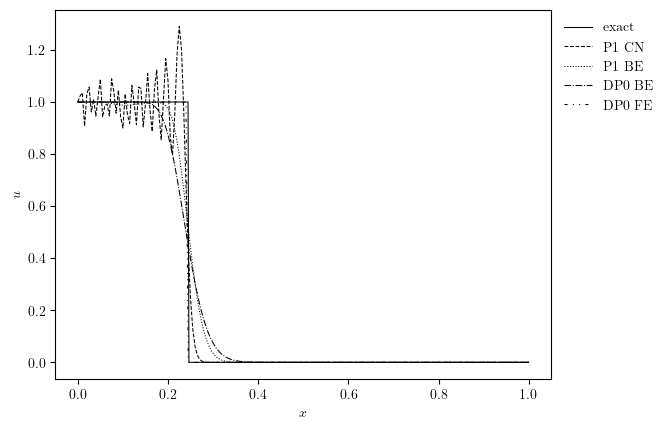

: 

In [ ]:
def exact_1d(
    x: np.ndarray, 
    t: float, 
    a: float,
    x0: float
) -> np.ndarray:
    u = np.zeros_like(x)
    u[x < x0 + a * t] = 1.0 
    return u

time_index = -1
times = [u.time_series[time_index] for u in results.values()]
assert all(np.isclose(t, times[0]) for t in times)
t = times[0]

x = np.linspace(0, Lx, num=500)
exact = exact_1d(x, t, a, x0)

legend_labels = ['exact', *results.keys()]
lines = [(x, exact), *(u.series[time_index] for u in results.values())]
plot_line(lines, legend_labels, x_label='$x$', y_label='$u$')

### $d=2$

$$\Omega = [0, L_x] \times [0, L_y]$$

$$\textbf{a} = \begin{pmatrix}
\sin(\pi x / L_x)\cos(\pi y / L_y) \\
-\cos(\pi x / L_x)\sin(\pi y / L_y)
\end{pmatrix}$$